In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider, Output, VBox
from IPython.display import display

file_path = 'C:/Users/semii/OneDrive/Masaüstü/veri_madenciliği/NYC_Crash_Model_Final_Last.csv' 

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError(f"HATA: Belirtilen dosya yolu '{file_path}' bulunamadı. Lütfen dosya adını/yolunu kontrol edin.")
except Exception as e:
    raise Exception(f"Veri okunurken bir hata oluştu: {e}")
    
features = [
    'LATITUDE', 'LONGITUDE', 
    'BOROUGH_BRONX', 'BOROUGH_BROOKLYN', 'BOROUGH_MANHATTAN', 
    'BOROUGH_QUEENS', 'BOROUGH_STATEN ISLAND'
]

X = df[features]
y = df['SEVERITY']

In [3]:
# --- 2. SMOTE ÖNCESİ VERİ DAĞILIMI ---
print("## 📊 SMOTE ÖNCESİ Veri Dağılımı")
distribution = Counter(y)
total_samples = len(y)
riskli_count = distribution.get(1, 0)
risksiz_count = distribution.get(0, 0)

print(f"  - Risksiz (0): {risksiz_count} ({risksiz_count/total_samples:.2%})")
print(f"  - Riskli (1): {riskli_count} ({riskli_count/total_samples:.2%})")

## 📊 SMOTE ÖNCESİ Veri Dağılımı
  - Risksiz (0): 1447826 (75.76%)
  - Riskli (1): 463247 (24.24%)


In [ ]:
# --- 3.SMOTE ile Veri Dengesizliğini Ortadan Kaldırma Ve Eğitim/Test Kümesine Ayırma ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 4. SMOTE Uygulama ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("## ✨ SMOTE SONRASI Eğitim Veri Dağılımı")
resampled_distribution = Counter(y_train_resampled)
print(f"  - Risksiz (0): {resampled_distribution.get(0)}")
print(f"  - Riskli (1): {resampled_distribution.get(1)}")

In [ ]:
#Karar Ağacı İle Eğitim

print("\n---Karar Ağacı Algoritması İle Eğitim---")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_resampled, y_train_resampled)
print("Karar Ağacı Eğitimi Tamamlandı.")

y_pred = dt_classifier.predict(X_test)
y_proba = dt_classifier.predict_proba(X_test)[:, 1] 

report = classification_report(y_test, y_pred, target_names=['Risksiz (0)', 'Riskli (1)'], output_dict=True)

precision_0 = report['Risksiz (0)']['precision']
recall_0 = report['Risksiz (0)']['recall']
f1_0 = report['Risksiz (0)']['f1-score']
support_0 = report['Risksiz (0)']['support']

precision_1 = report['Riskli (1)']['precision']
recall_1 = report['Riskli (1)']['recall']
f1_1 = report['Riskli (1)']['f1-score']
support_1 = report['Riskli (1)']['support']

accuracy = report['accuracy']
macro_avg_p = report['macro avg']['precision']
macro_avg_r = report['macro avg']['recall']
macro_avg_f1 = report['macro avg']['f1-score']
weighted_avg_p = report['weighted avg']['precision']
weighted_avg_r = report['weighted avg']['recall']
weighted_avg_f1 = report['weighted avg']['f1-score']
total_test_samples = support_0 + support_1

conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
accuracy_total = accuracy_score(y_test, y_pred)


print("\n---Değerlendirme Raporu---")
print("{:<12}{:<10}{:<10}{:<10}{:<10}".format("", "precision", "recall", "f1-score", "support"))
print("{:<12}{:<10.2f}{:<10.2f}{:<10.2f}{:<10}".format("Risksiz (0)", precision_0, recall_0, f1_0, support_0))
print("{:<12}{:<10.2f}{:<10.2f}{:<10.2f}{:<10}".format("Riskli (1)", precision_1, recall_1, f1_1, support_1))
print("\n")
print("{:<12}{:<10}{:<10}{:<10.2f}{:<10}".format("accuracy", "", "", accuracy, total_test_samples))
print("{:<12}{:<10.2f}{:<10.2f}{:<10.2f}{:<10}".format("macro avg", macro_avg_p, macro_avg_r, macro_avg_f1, total_test_samples))
print("{:<12}{:<10.2f}{:<10.2f}{:<10.2f}{:<10}".format("weighted avg", weighted_avg_p, weighted_avg_r, weighted_avg_f1, total_test_samples))


print("\nDoğruluk (Accuracy): {}".format(accuracy_total))
print("ROC AUC Skoru: {:.4f}".format(roc_auc))

print("\n--- Görsel Karışıklık Matrisi (Heatmap) ---")
class_names = ['Risksiz (0)', 'Riskli (1)']
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names 
)
plt.title('Karışıklık Matrisi (Decision Tree)')
plt.ylabel('Gerçek Sınıf (True Label)')
plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')
plt.show()

MODEL_ADI_DT = 'C:/Users/semii/OneDrive/Masaüstü/veri_madenciliği/modeller/decision_tree_spatial_risk_model.joblib' 
dump(dt_classifier, MODEL_ADI_DT)
print(f"\nModel başarıyla kaydedildi")

In [ ]:
#Lojistik Regresyon İle Eğitim

print("---Lojistik Regresyon Algoritması İle Eğitim---")

model_lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)

model_lr.fit(X_train, y_train)
print("Lojistik Regresyon Eğitimi Tamamlandı.")

y_pred_lr = model_lr.predict(X_test)

print("\n--- Değerlendirme Raporu ---")
print(classification_report(y_test, y_pred_lr, target_names=['Risksiz (0)', 'Riskli (1)']))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_lr))

y_proba_lr = model_lr.predict_proba(X_test)[:, 1]

roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"ROC AUC Skoru: {roc_auc_lr:.4f}")
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr) 
print("\n--- Görsel Karışıklık Matrisi (Heatmap) ---")
class_names = ['Risksiz (0)', 'Riskli (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_lr, 
    annot=True,
    fmt='d', 
    cmap='PuBu', 
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Karışıklık Matrisi (Lojistik Regresyon)')
plt.ylabel('Gerçek Sınıf (True Label)')
plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')

plt.show()

MODEL_ADI = 'C:/Users/semii/OneDrive/Masaüstü/veri_madenciliği/modeller/logistic_regression_spatial_risk_model.joblib'
joblib.dump(model_lr, MODEL_ADI)

print(f"\nModel başarıyla kaydedildi")

In [ ]:
#NAIVE BAYES algoritması ile eğitim

print("---NAIVE BAYES Algoritması İle Eğitim Tamamlandı---")

model_gnb = GaussianNB()
model_gnb.fit(X_train_resampled, y_train_resampled)
print("Naive Bayes Eğitimi Tamamlandı.")


y_pred_gnb = model_gnb.predict(X_test)

print("\n---Değerlendirme Raporu---")
print(classification_report(y_test, y_pred_gnb, target_names=['Risksiz (0)', 'Riskli (1)']))
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_gnb))

y_proba_gnb = model_gnb.predict_proba(X_test)[:, 1]
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb) 
roc_auc_gnb = roc_auc_score(y_test, y_proba_gnb)
print(f"ROC AUC Skoru: {roc_auc_gnb:.4f}")

print("\n--- Görsel Karışıklık Matrisi (Heatmap) ---")

class_names = ['Risksiz (0)', 'Riskli (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_gnb, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=class_names, 
    yticklabels=class_names
)
plt.title('Karışıklık Matrisi (Naive Bayes)')
plt.ylabel('Gerçek Sınıf (True Label)')
plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')

plt.show()

MODEL_ADI_GNB = 'C:/Users/semii/OneDrive/Masaüstü/veri_madenciliği/modeller/gaussian_nb_spatial_risk_model.joblib'
joblib.dump(model_gnb, MODEL_ADI_GNB)

print(f"\nModel başarıyla kaydedildi")

In [ ]:
# Test Kısmı
MODEL_PATHS = {
    "Karar Ağacı (DT)": 'C:/Users/semii/OneDrive/Masaüstü/veri_madenciliği/modeller/decision_tree_spatial_risk_model.joblib',
    "Lojistik Regresyon (LR)": 'C:/Users/semii/OneDrive/Masaüstü/veri_madenciliği/modeller/logistic_regression_spatial_risk_model.joblib',
    "Naive Bayes (NB)": 'C:/Users/semii/OneDrive/Masaüstü/veri_madenciliği/modeller/gaussian_nb_spatial_risk_model.joblib'
}

FEATURES = [
    'LATITUDE', 'LONGITUDE', 
    'BOROUGH_BRONX', 'BOROUGH_BROOKLYN', 'BOROUGH_MANHATTAN', 
    'BOROUGH_QUEENS', 'BOROUGH_STATEN ISLAND'
]

loaded_models = {}
for name, path in MODEL_PATHS.items():
    try:
        loaded_models[name] = joblib.load(path)
    except FileNotFoundError:
        print(f"UYARI: {name} modeli bulunamadı: {path}. Bu model kullanılamayacak.")
        loaded_models[name] = None
    except Exception as e:
        print(f"UYARI: {name} yüklenirken hata: {e}")
        loaded_models[name] = None

def predict_risk(model_name, latitude, longitude, selected_borough):
    """Seçilen model ve girdilere göre risk tahmini yapar."""
    
    model = loaded_models.get(model_name)
    if model is None:
        return "Model yüklenemediği için tahmin yapılamıyor."

    input_data = {feature: [0] for feature in FEATURES}
    input_data['LATITUDE'] = [latitude]
    input_data['LONGITUDE'] = [longitude]

    borough_col = f'BOROUGH_{selected_borough}'
    if borough_col in input_data:
        input_data[borough_col] = [1]
    
    input_df = pd.DataFrame(input_data)
    
    try:
        prediction = model.predict(input_df)[0]
        prediction_proba = model.predict_proba(input_df)[0]
        risk_proba = prediction_proba[1] 

        result = f"Model: **{model_name}**\n"
        result += f"Risk Olasılığı: **{risk_proba:.2%}**\n"
        
        if prediction == 1:
            result += "Tahmin: ⚠️ **RİSKLİ BÖLGE TESPİT EDİLDİ (Sınıf 1)**"
        else:
            result += "Tahmin: ✅ **RİSKSİZ BÖLGE TESPİT EDİLDİ (Sınıf 0)**"
            
        return result
    
    except Exception as e:
        return f"Tahmin sırasında hata oluştu: {e}"


model_widget = Dropdown(
    options=[k for k, v in loaded_models.items() if v is not None],
    description='Model Seç:',
    style={'description_width': 'initial'}
)

latitude_widget = FloatSlider(
    min=40.5, max=40.92, step=0.001, value=40.73, 
    description='LATITUDE:',
    style={'description_width': 'initial'}, layout={'width': '500px'}
)

longitude_widget = FloatSlider(
    min=-74.25, max=-73.7, step=0.001, value=-73.99, 
    description='LONGITUDE:',
    style={'description_width': 'initial'}, layout={'width': '500px'}
)

borough_widget = Dropdown(
    options=['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
    description='İlçe Seç:',
    style={'description_width': 'initial'}
)

print("=== 🌎 İnteraktif Coğrafi Risk Tahmincisi (ipywidgets) ===")
print("Lütfen soldaki menüden model ve girdileri değiştirin.")

interact(
    predict_risk,
    model_name=model_widget,
    latitude=latitude_widget,
    longitude=longitude_widget,
    selected_borough=borough_widget
);

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score

dt_report = classification_report(y_test, y_pred, output_dict=True, target_names=['Risksiz (0)', 'Riskli (1)'])
lr_report = classification_report(y_test, y_pred_lr, output_dict=True, target_names=['Risksiz (0)', 'Riskli (1)'])
gnb_report = classification_report(y_test, y_pred_gnb, output_dict=True, target_names=['Risksiz (0)', 'Riskli (1)'])

results = {
    'Model': ['Karar Ağacı', 'Lojistik Regresyon', 'Naive Bayes'],
    'Riskli (1) Precision': [dt_report['Riskli (1)']['precision'], lr_report['Riskli (1)']['precision'], gnb_report['Riskli (1)']['precision']],
    'Riskli (1) Recall': [dt_report['Riskli (1)']['recall'], lr_report['Riskli (1)']['recall'], gnb_report['Riskli (1)']['recall']],
    'Riskli (1) F1-Score': [dt_report['Riskli (1)']['f1-score'], lr_report['Riskli (1)']['f1-score'], gnb_report['Riskli (1)']['f1-score']],
    'ROC AUC': [roc_auc_score(y_test, y_proba), roc_auc_score(y_test, y_proba_lr), roc_auc_score(y_test, y_proba_gnb)],
    'Overall Accuracy': [dt_report['accuracy'], lr_report['accuracy'], gnb_report['accuracy']] 
}
df_results = pd.DataFrame(results)

print("## 📑 Karşılaştırmalı Metrik Tablosu (Riskli Sınıf ve Genel Başarı)")
display(df_results)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Overall Accuracy', data=df_results, palette='viridis', hue='Model', legend=False)
plt.title('Modellerin Genel Başarı (Accuracy) Karşılaştırması')
plt.ylabel('Doğruluk (Accuracy) Skoru')
plt.ylim(0, 1) 
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

print("## 📈 Karşılaştırmalı ROC Eğrisi")

models = {
    'Karar Ağacı': y_proba,
    'Lojistik Regresyon': y_proba_lr,
    'Naive Bayes': y_proba_gnb
}

plt.figure(figsize=(10, 8))

for name, proba in models.items():
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'r--', label='Rastgele Tahmin (AUC = 0.50)')

plt.xlabel('Hatalı Pozitif Oranı (False Positive Rate)')
plt.ylabel('Doğru Pozitif Oranı / Recall (True Positive Rate)')
plt.title('Modellerin ROC Eğrisi Karşılaştırması')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 🎯 Precision ve Recall Metrikleri Karşılaştırması


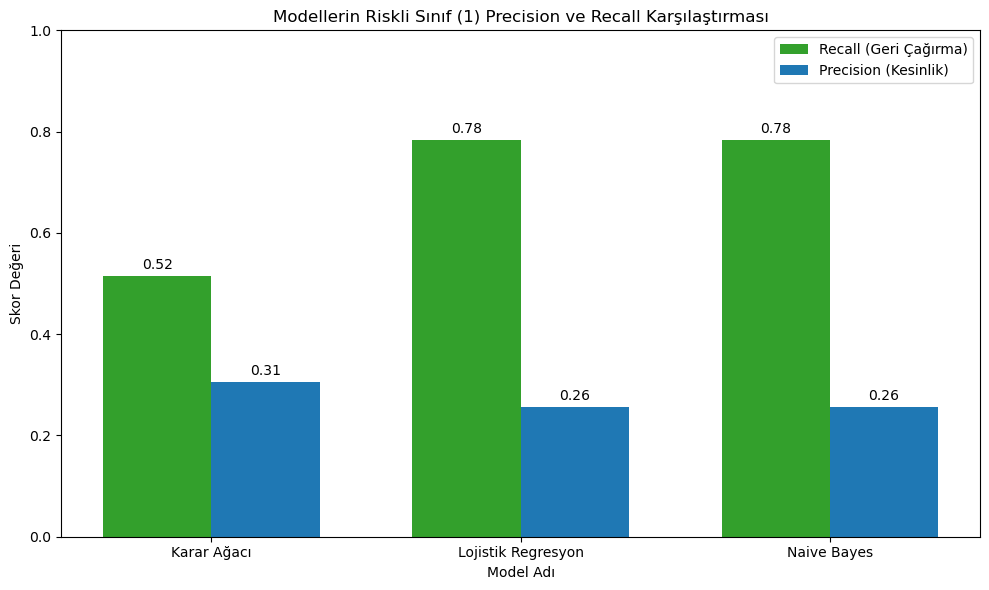

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("## 🎯 Precision ve Recall Metrikleri Karşılaştırması")
metrics = ['Riskli (1) Recall', 'Riskli (1) Precision']
model_names = df_results['Model']

x = np.arange(len(model_names))
width = 0.35 

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, df_results[metrics[0]], width, label='Recall (Geri Çağırma)', color='#33a02c')

rects2 = ax.bar(x + width/2, df_results[metrics[1]], width, label='Precision (Kesinlik)', color='#1f78b4')

ax.set_ylabel('Skor Değeri')
ax.set_xlabel('Model Adı')
ax.set_title('Modellerin Riskli Sınıf (1) Precision ve Recall Karşılaştırması')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.set_ylim(0, 1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()